In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from attrbench import datasets, attribution, models
from attrbench.evaluation.insertion_curves import insertion_curves
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
import matplotlib as mpl
import torch
mpl.rcParams['figure.dpi'] = 150

In [3]:
# General parameters
dataset_name = "MNIST"
batch_size = 64
n_batches = 16
use_logits = False
data_root = "../data"
aggregation_fn = "avg"
normalize_attrs = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [4]:
# CIFAR10 parameters
if dataset_name == "CIFAR10":
    model_name = "resnet18"
    insert_range = list(range(1, 900, 100))
    dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, "CIFAR10"), download=False, shuffle=False, version="cifar10")
    model = model = models.Resnet(version=model_name, params_loc=path.join(data_root, f"models/{dataset_name}/{model_name}.pt"),
                      output_logits=use_logits, num_classes=10)
    model.to(device)
    model.eval()

In [5]:
# MNIST parameters
if dataset_name == "MNIST":
    insert_range = list(range(1, 128, 10))
    dataset = datasets.MNIST(batch_size=batch_size, data_location=path.join(data_root, "MNIST"), download=False, shuffle=False)
    model = models.BasicCNN(params_loc=path.join(data_root, "models/MNIST/cnn.pt"), output_logits=use_logits, num_classes =10)
    model.to(device)
    model.eval()

In [6]:
kwargs = {
    "normalize": normalize_attrs,
    "aggregation_fn": aggregation_fn
}

attribution_methods = {
    #"GuidedGradCAM": attribution.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": attribution.Gradient(model, **kwargs),
    "InputXGradient": attribution.InputXGradient(model, **kwargs),
    "IntegratedGradients": attribution.IntegratedGradients(model, **kwargs),
    "GuidedBackprop": attribution.GuidedBackprop(model, **kwargs),
    "Deconvolution": attribution.Deconvolution(model, **kwargs),
}


In [7]:
result = insertion_curves(itertools.islice(dataset.get_dataloader(train=False), n_batches), model,
                          attribution_methods, insert_range, dataset.mask_value, pixel_level_mask=aggregation_fn is not None,
                          device=device)

0it [00:00, ?it/s]/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.7/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
16it [00:08,  1.86it/s]


In [8]:
result_df = pd.DataFrame.from_dict(
    {m_name: pd.DataFrame(data=result[m_name]).stack() for m_name in attribution_methods}
).stack().reset_index()
result_df.columns = ["sample", "insertion", "method", "difference"]
result_df["insertion"] = np.array(insert_range)[result_df["insertion"]]

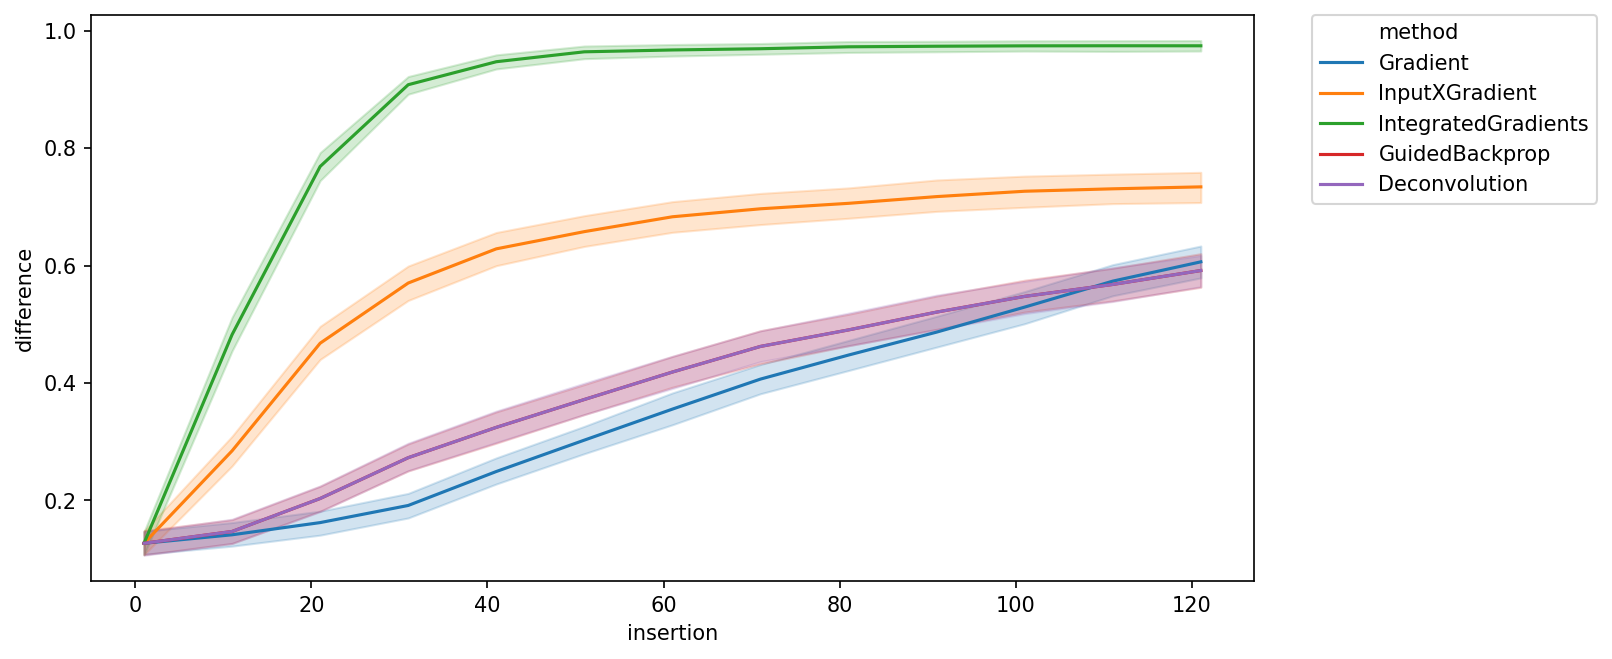

In [10]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="insertion", y="difference", hue="method", data=result_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)